In [30]:
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
data = np.loadtxt('gmm_dataset.csv', delimiter=",")
n, d = data.shape

In [32]:
# labels = []
# for i in range(n):
#     labels.append(np.random.dirichlet(np.ones(2),size=1)[0])
# labels = np.array(labels)

In [39]:
# From below, we have that this function is of time complexity O(knd)
# Space complexity is O(kd)
def get_params_from_labels(frac_labels, X, k):
    r_k = np.sum(frac_labels, axis=0) # This is size k
    pi_k = r_k / X.shape[0] #This is also Size K

    mu_k = [] # From below, this is an kxd array
    S_k = [] # From below, this is an kxd array
    for i in range(k): # This Loop happens k times
        # For loop runs n times and multiplying a (scalar) by b (d x 1) is time d
        u_k0 = np.array([a * b for a, b in zip(frac_labels[:,i], X)]) #Therefore, this line takes O(nd)
        u_k = np.sum(u_k0, axis = 0) / r_k[i] # Sum over n elements to get an array of length d
        mu_k.append(u_k)

        # For loop runs n times and multiplying b by b.t is O(d)
        s_k0 = np.array([a * b * b.T for a, b in zip(frac_labels[:,i], X)]) #Therefore, this line takes O(nd)
        s_k1 = np.sum(s_k0, axis = 0) / r_k[i] # Sum over n elements to get an array of length d
        s_k2 = s_k1 - mu_k[i] * mu_k[i].T
        s_k_rep = np.where(s_k2 == 0, 0.00001, s_k2)
        S_k.append(s_k1 - mu_k[i] * mu_k[i].T)
    
    return pi_k, mu_k, S_k

In [40]:
# From below, we have that this function is of time complexity O(knd)
# Space Complexity is O(kn)
def get_labels_from_params(pi_k, mu_k, S_k, X, K):
    labels = np.zeros((X.shape[0],K)) # Create a k by n array
    
    for k in range(K): # This Loop happens k times
        p = pi_k[k]
        d = (np.prod(S_k[k]) ** (-0.5)) # Multiplying all the d elements in S_K is O(d)

        r_ik = p * d * np.exp(-0.5 * np.sum(np.multiply((np.subtract(X, mu_k[k]) * (1 / S_k[k])), np.subtract(X, mu_k[k])), axis = 1))

        labels[:,k] = np.array(r_ik)

    r_i = np.sum(labels, axis = 1) # Added over k to create an n sized array
    labels = np.array([a / b for a, b in zip(labels, r_i)])
    
    return r_i, labels

In [41]:
# Time complexity is O(max_iter*k*n*d)
# Space complexity is O(max_iter + kn + kd)
def gmm_em(X, k, max_iter=500, tol = 0.00001):
    n, d = X.shape
    
    # Randommly initialize labels
    labels = []
    for i in range(n): # For loop run n times
        labels.append(np.random.dirichlet(np.ones(k),size=1)[0]) #This take O(k)
    labels = np.array(labels)
    
    pi_k, mu_k, S_k = get_params_from_labels(labels, X, k)
    loss = [] #This is eventually an array of size O(max_iter)
    
    for iterat in range(max_iter): # Run at most max_iter times
        print(f"iterat, {iterat}")
        r_i, labels = get_labels_from_params(pi_k, mu_k, S_k, X, k) #O(knd) runtime and labels is O(kn) space
        
        #These operations are less than O(knd)
        new_loss = -np.sum(np.array([np.log(r) for r in r_i]))
        loss.append(new_loss) # Add a number in max_iter times
        if len(loss) > 1 and abs(loss[-2] - new_loss) <= tol * new_loss:
            break
        
        pi_k, mu_k, S_k = get_params_from_labels(labels, X, k) #O(knd) runtime and mu_k/S_k is O(kd) space
    return pi_k, mu_k, S_k, loss

In [36]:
pis = []
mus = []
Ss = []
losses = []
for k in range(1, 11):
    pi_k, mu_k, S_k, loss = gmm_em(data, k)
    
    pis.append(pi_k)
    mus.append([mat.round(2) for mat in mu_k])
    Ss.append([mat.round(2) for mat in S_k])
    losses.append(loss)

Text(0, 0.5, 'Final Model - Negative Log Likelihood')

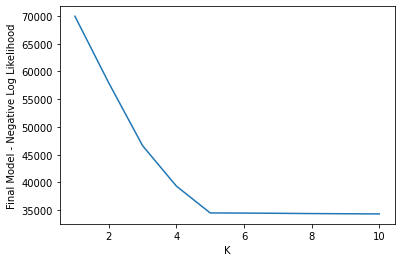

In [37]:
losses_k = [l[-1] for l in losses]

plt.plot(range(1,11), losses_k)
plt.xlabel('K')
plt.ylabel('Final Model - Negative Log Likelihood')
# plt.savefig("k_loss.png")

In [11]:
k_chose = 6
best_k_df = pd.DataFrame(np.array([pis[k_chose - 1], mus[k_chose - 1], Ss[k_chose - 1]], dtype=object).T, columns = ['MixingWeights','MeanVectors','CovarianceDiagonals']).sort_values(by="MixingWeights").reset_index(drop=True)

pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
display(best_k_df)

,MixingWeights,MeanVectors,CovarianceDiagonals
0,0.0996552,"[1.69, 0.4, 0.99, 2.35, 1.89, -0.96, 0.89, -0.19, -0.09, 0.34, 0.04, 1.4, 0.74, 0.11, 0.42, 0.33, 1.46, -0.21, 0.29, -0.85]","[1.72, 1.19, 1.41, 0.89, 1.18, 2.05, 0.38, 0.68, 1.83, 1.54, 1.75, 0.88, 0.8, 1.98, 0.26, 0.83, 0.95, 0.14, 0.56, 0.92]"
1,0.0999983,"[-2.56, 0.6, 0.91, -0.71, 2.31, -1.44, 0.06, -0.18, 1.52, 1.47, 0.13, 0.41, -0.85, -1.98, -0.32, 0.18, 1.22, 1.21, -0.44, -0.32]","[0.36, 1.08, 0.28, 1.33, 0.69, 0.15, 0.41, 1.79, 0.76, 0.39, 0.65, 0.55, 0.61, 0.03, 0.66, 0.72, 0.61, 0.2, 0.38, 1.03]"
2,0.126395,"[-0.59, -0.43, -0.69, -1.71, 0.5, -0.39, -1.61, 0.66, -0.87, 0.16, 0.91, 0.06, 1.1, -1.21, 0.58, -0.71, -0.82, -0.47, -0.27, 0.06]","[0.47, 1.68, 1.13, 0.08, 1.04, 0.85, 1.09, 1.35, 1.25, 0.32, 0.73, 0.35, 0.66, 0.55, 1.12, 0.78, 0.87, 0.72, 0.39, 0.02]"
3,0.173606,"[-0.72, -0.38, -0.94, -1.72, -0.04, -0.36, -1.67, 0.35, -1.0, -0.06, 0.63, 0.11, 1.19, -1.21, 0.33, -0.7, -0.95, -0.65, -0.36, 0.05]","[0.51, 2.04, 0.86, 0.09, 1.22, 0.8, 0.9, 1.65, 1.01, 0.29, 0.95, 0.34, 0.96, 0.78, 1.01, 0.59, 0.67, 0.64, 0.48, 0.02]"
4,0.199998,"[-1.04, -1.39, -1.71, 1.92, -0.54, -0.44, -1.28, 0.77, -1.58, -0.22, -0.89, 0.39, -0.54, -1.17, -0.04, 0.44, 0.05, 0.3, -0.65, -0.35]","[1.6, 0.45, 0.17, 0.61, 2.49, 0.89, 0.87, 1.16, 1.38, 0.47, 0.07, 1.75, 0.75, 0.8, 0.1, 0.67, 1.13, 1.03, 1.14, 0.44]"
5,0.300348,"[-1.15, 0.94, 0.47, -1.55, 1.51, 1.93, 1.2, -0.18, -1.06, 1.09, -0.33, 1.23, 0.21, 0.97, 0.35, 0.72, 0.01, 1.81, 0.09, 0.4]","[0.35, 1.3, 0.66, 2.27, 0.63, 1.58, 1.13, 0.05, 0.75, 1.64, 1.29, 0.28, 0.04, 1.1, 0.51, 0.17, 0.78, 0.77, 2.13, 1.36]"


In [30]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.array([np.ravel(train) for train in x_train])
x_test = np.array([np.ravel(test) for test in x_test])

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
k = 5
X = x_train[y_train == 0]
gmm_em(X, k, max_iter=500, tol = 0.00001)

In [14]:
k = 2
labels = []
for i in range(n): # For loop run n times
    labels.append(np.random.dirichlet(np.ones(k),size=1)[0]) #This take O(k)
labels = np.array(labels)

pi_k, mu_k, S_k = get_params_from_labels(labels, data, k)

In [ ]:
for i in range(X.shape[0]): # This Loop happens n times
    zippy = zip(X[i] - mu_k[k], (1 / S_k[k])) # All O(d) operations
    thing0 = np.array([a * b for a, b in zippy]) # Scalar multiplication of for loop run d times
    thing = p * d  * math.exp(-0.5 * np.matmul(thing0, (X[i] - mu_k[k]))) # Matric multiplication of [1xd] and [dx1] is O(d)
    r_ik.append(thing)

In [29]:
p * d * np.exp(-0.5 * np.sum(np.multiply((np.subtract(data, mu_k[0]) * (1 / S_k[0])), np.subtract(data, mu_k[0])), axis = 1))

array([4.46645888e-07, 2.95304127e-05, 2.72491560e-05, ...,
       3.49561764e-05, 9.08692015e-06, 2.59379834e-05])

In [26]:
np.sum((np.subtract(data, mu_k[0]) * (1 / S_k[0]))[0] * np.subtract(data, mu_k[0])[0])

29.24299950757422

In [24]:
np.matmul((np.subtract(data, mu_k[0]) * (1 / S_k[0]))[0] , np.subtract(data, mu_k[0])[0])

29.24299950757422